In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import GroverOperator, MCMT, ZGate

- get simulator

In [2]:
simulator = Aer.get_backend('qasm_simulator')

- build superposition

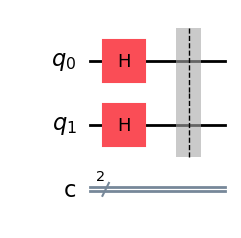

In [3]:
def initQC(n):
    # params: n -- num of qubits
    qc = QuantumCircuit(n, n)

    for i in range(n):
        qc.h(i)
    qc.barrier() # differentiate area
    return qc

initCircuit2Q = initQC(2)
initCircuit2Q.draw(output='mpl')

- build oracle to search $\ket{11}$ - as example

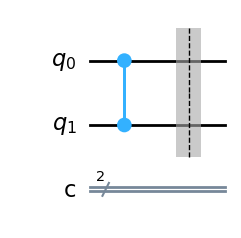

In [4]:
def groverOracle3():
    qc = QuantumCircuit(2,2)

    # gates for finding 3
    qc.cz(0,1)
    qc.barrier()

    return qc

oracleCircuit3 = groverOracle3()
oracleCircuit3.draw(output='mpl')

In [5]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

- verify oracle above

In [6]:
from qiskit.quantum_info import Operator

transMat = Operator(oracleCircuit3).data
transMat

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [7]:
from functools import reduce
import numpy as np

Kron = lambda *matrices: reduce(np.kron, matrices) # tensor product
state_0 = np.array([1, 0]) # |0>
state_1 = np.array([0, 1]) # |1>

# all possible states
state_00 = Kron(state_0, state_0) # |00>
state_01 = Kron(state_0, state_1) # |01>
state_10 = Kron(state_1, state_0) # |10>
state_11 = Kron(state_1, state_1) # |11>

print("O|00>", transMat @ state_00) # @ 为矩阵乘法计算
print("O|01>", transMat @ state_01)
print("O|10>", transMat @ state_10)
print("O|11>", transMat @ state_11) # flip phase

O|00> [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
O|01> [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
O|10> [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
O|11> [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]


- Inversion about Mean
  - 2A-I

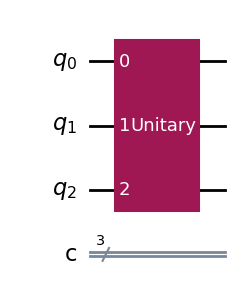

In [8]:
# build IaM circuit
def buildIaM(n):
    # params: n - num of qubits
    qc = QuantumCircuit(n,n)
    qcIndex = list(range(n))
    mat = np.full((2**n, 2**n), (2/(2**n)))
    np.fill_diagonal(mat, (2/(2**n))-1)
    IaMGate = Operator(mat)
    qc.append(IaMGate, qcIndex)
    return qc

IaMCircuit = buildIaM(3)
IaMCircuit.draw(output='mpl')

- combine all together

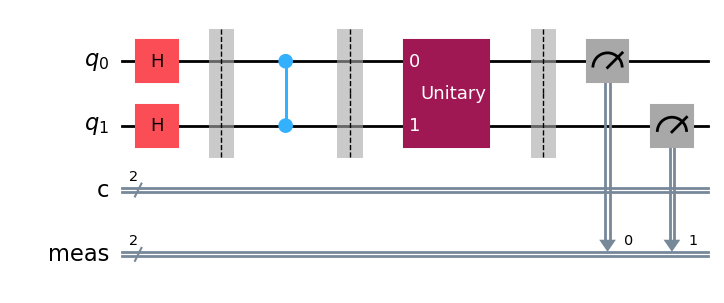

In [9]:
def composeCircuit(n, oracle):
    qc = QuantumCircuit(n,n)
    initial = initQC(n)
    # oracle = groverOracle3()
    iam = buildIaM(n)
    qc = qc.compose(initial)
    qc = qc.compose(oracle)
    qc = qc.compose(iam)
    qc.measure_all()
    return qc

oracle3 = groverOracle3()
qc = composeCircuit(2, oracle3)
qc.draw(output='mpl')


- run sample on simulator

/tmp/ipykernel_9061/2104768423.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=simulator)


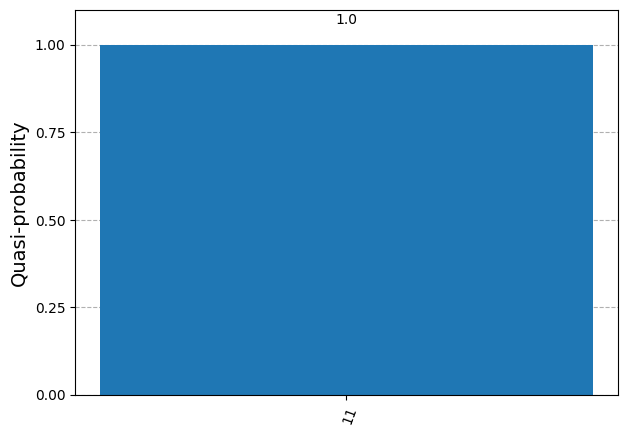

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=simulator)
sampler.options.default_shots = 10_000
result = sampler.run([qc]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

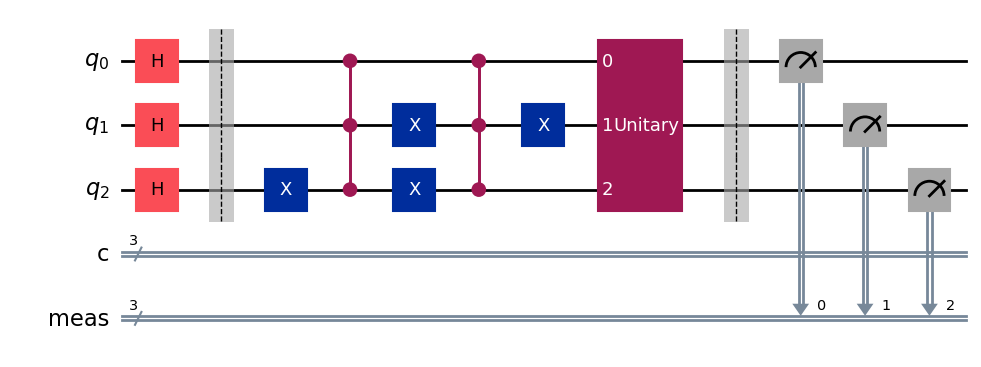

In [11]:
marked_states = ["011", "101"]
oracle = grover_oracle(marked_states)
qc2 = composeCircuit(3, oracle)
qc2.draw(output='mpl')

In [72]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=simulator)
sampler.options.default_shots = 10000
qc2.remove_final_measurements()  # no measurements allowed
from qiskit.quantum_info import Statevector
statevector = Statevector(qc2)
# result = sampler.run([qc2]).result()
# dist = result[0].data.meas.get_counts()
# print(result)
# plot_distribution(dist)
statevector

Statevector([-5.55111512e-17-7.97972799e-16j,
              0.00000000e+00+2.85877953e-17j,
              0.00000000e+00+6.24500451e-17j,
              7.07106781e-01+1.67227343e-15j,
              0.00000000e+00+6.24500451e-17j,
              7.07106781e-01+1.65062453e-15j,
             -5.55111512e-17-7.97972799e-16j,
              5.55111512e-17+3.46944695e-17j],
            dims=(2, 2, 2))


/tmp/ipykernel_9061/1209523655.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=simulator)


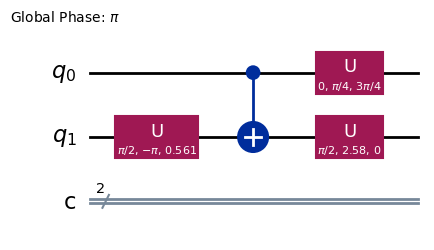

In [41]:
# -Controlled-Z
def buildRevCZ():
    # params: n - num of qubits
    qc = QuantumCircuit(2,2)
    qcIndex = list(range(2))
    mat = np.zeros((4,4))
    np.fill_diagonal(mat, -1)
    mat[3,3] = 1
    IaMGate = Operator(mat)
    qc.append(IaMGate, qcIndex)
    return qc

qc = buildRevCZ()
qc.decompose().draw(output='mpl')

In [65]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# 创建量子电路
qc = QuantumCircuit(2, 2)

# 对量子比特应用Hadamard门
qc.h(0)

# 应用Ry门进行旋转
theta = 0.25  # 假设x=1，0.25是多项式中的系数
qc.ry(theta, 0)

# 测量
qc.measure(0, 1)

# 运行模拟器
simulator = Aer.get_backend('qasm_simulator')
sampler = Sampler(backend=simulator)
sampler.options.default_shots = 10000
result1 = sampler.run([qc]).result()
dist1 = result1[0].data.meas.get_counts()

# 显示结果
plot_histogram(dist1)

/tmp/ipykernel_9061/4174893263.py:20: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=simulator)


AttributeError: 'DataBin' object has no attribute 'meas'

- test on 2 qubit circuit

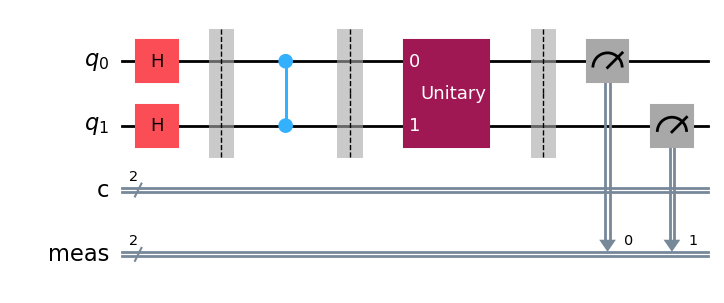

In [55]:
oracle2 = groverOracle3()
qc3 = composeCircuit(2, oracle2)
qc3.draw(output='mpl')